# STA 208: Homework 2 (Do not distribute)

## Due 4/24/19 at midnight

__Instructions:__ To make grading easier for the TAs please submit it on canvas in a zip file with either the scanned solutions clearly written or in the jupyter notebook below.  The zip file should include all of your code either in this notebook file, or a separate python file that is imported and ran in this notebook.  We should be able to open this notebook and run everything here by running the cells in sequence.  The written portions can be either done in markdown and TeX in new cells or written clearly by hand and scanned.

- Code should be well organized and documented
- All math should be clear and make sense sequentially
- When in doubt explain what is going on
- You will be graded on correctness of your math, code efficiency and succinctness, and conclusions and modelling decisions

__Exercise 1__ (30 pts)

Consider Poisson model with rate parameter $\lambda$ which has PMF,
$$
p(y|\lambda) = \frac{\lambda^y}{y!} e^{-\lambda},
$$
where $y = 0,1,\ldots$ is some count variable.
In Poison regression, we model $\lambda = e^{\beta^\top x}$ to obtain $p(y | x,\beta)$.

1. Let the loss function for Poisson regression be $\ell_i(\beta) \propto - \log p(y_i | x_i, \beta)$ for a dataset consisting of predictor variables and count values $\{x_i,y_i\}_{i=1}^n$.  Here $\propto$ means that we disregard any additive terms that are not dependent on $\beta$.  Write an expression for $\ell_i$ and derive its gradient. 
2. Show that the empirical risk $R_n(\beta)$ is a convex function of $\beta$.
3. Consider the mapping $F_\eta(\beta) = \beta - \eta \nabla R_n(\beta)$ which is the iteration of gradient descent ($\eta>0$ is called the learning parameter).  Show that at the minimizer of $R_n$, $\hat \beta$, we have that $F(\hat \beta) = \hat \beta$.
4. I have a script to simulate from this model below.  Implement the gradient descent algorithm above and show that with enough data (n large enough) the estimated $\hat \beta$ approaches the true $\beta$ (you can look at the sum of square error between these two vectors).

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
## Simulate from the Poisson regression model (use y,X)
n, p = 1000,20
X = np.random.normal(0,1,size = (n,p))
beta = np.random.normal(0,.2,size = (p))
lamb = np.exp(X @ beta)
y = np.random.poisson(lamb)

MSE = []
eta=0.005
beta_hat = np.random.normal(0,0.5,size = (p)) # random initailization of beta
for iteration in range(0,1000):
    grad_R = (1/n)*X.T@(np.exp(X @ beta_hat) - y)
    
    beta_hat = beta_hat - eta*grad_R
    #print((np.square(beta - beta_hat)).mean(axis=0))
    MSE.append(np.square(beta - beta_hat).mean(axis=0))

Text(0, 0.5, 'MSE')

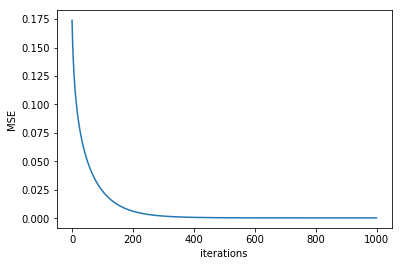

In [21]:
#plot MSE
plt.plot(np.arange(0,1000),MSE)
#plt.ylim(0,10)
plt.xlabel('iterations')
plt.ylabel('MSE')

__Exercise 2__ (30 pts)

Recall the subset selection problem with tuning parameter $k$,
$$
\min_{\beta : {\rm supp}(\beta) \le k}\| y - X \beta \|_2^2.
$$

1. Write the subset selection problem in the following form
$$
\min_{S \subseteq \{1,\ldots,p\}, |S|\le k} y^\top P_S y,
$$
where $P_S$ is a projection.  Describe the subspace that is the range of this projection.
2. Suppose that we have a nested sequence of models $S_1\subset S_2 \subset \ldots \subset S_p$ such that $|S_k| = k$ (it contains $k$ variables).  Prove that $$y^\top P_{S_k} y \ge y^\top P_{S_{k+1}} y$$ for $k=1,\ldots,p-1$.  What does this tell us about the solution to the subset selection problem and the constraint $|S| \le k$?
3. Suppose that $X$ is orthogonal, then write a computationally efficient pseudocode to solve the subset selection problem.  Prove that it is correct (your algorithm actually solves subset selection under othogonal design).
4. (Challenge) Suppose that we have that $n = p$ and $y_i = \beta_i + \epsilon_i$ (identity design matrix) where $\epsilon_i$ satisfies 
$$
\mathbb P \left\{ |\epsilon_i| \ge t \right\} \le 2 e^{-t^2 / 2\sigma^2}
$$
for any $t > 0$ (this is true for central Normal RVs) for some $\sigma > 0$.
Suppose that there is some true $S_0 \subset\{1,\ldots,p\}$ such that $|S_0| = k < p$ and ${\rm supp}(\beta) = S_0$.
Prove the following.

__Proposition__
Define $\mu = \min_{j \in S_0} |\beta_j|$ and call $\mu / \sigma$ the signal-to-noise ratio.  Then if 
$$
\frac{\mu}{\sigma} > 2 \sqrt{2 \log \left( \frac{2n}{\delta}\right)},
$$
then the true $S$ is selected by subset selection with probability at least $1 - \delta$.

Hint: rewrite the subset selection problem with $X = I$ and compare the objective at $S_0$ to any other $S$.

__Exercise 3__ (40 pts)
For this exercise, it may be helpful to use the `sklearn.linear_model` module.  I have also included a plotting tool for making the lasso path in ESL.

1. Load the training and test data using the script below.  Fit OLS on the full dataset and compute the test error.  Throughout you do not need to compute an intercept but you should normalize the X (divide by the column norms).
2. Train and tune ridge regression and compute the test error (square error loss).
3. Fit the lasso path to the data and compute the test error for each returned lasso coefficient.
4. Compare and contrast the lars path to the lasso path, what is the key difference.  Tell me when the active sets differ and how, if they do at all.
4. Extract each active set from the lasso path and 
































compute the restricted OLS for each.  Compute and compare the test error for each model.
5. If your boss said that they wanted a more parsimonious model (a smaller model) then which model would you choose, justify your answer.  Under which circumstance would you choose the model with the smallest test error.

In [22]:
def plot_lars(coefs, lines=False, title="Lars Path"):
    """
    Plot the lasso path where coefs is a matrix - the columns are beta vectors
    """
    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    if lines:
        plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title(title)
    plt.axis('tight')

In [23]:
import pickle
import numpy as np
from sklearn import model_selection, linear_model, neighbors, preprocessing, metrics
import matplotlib.pyplot as plt

with open('hw2.data','rb') as f:
    y_tr,X_tr,y_te,X_te = pickle.load(f)
    
X_tr.shape, y_tr.shape

((1000, 100), (1000,))

In [24]:
#standerdize x values
norm = np.linalg.norm(X_tr,axis=0)
X_tr = X_tr/norm
X_te = X_te/norm



#OLS
lr = linear_model.LinearRegression(fit_intercept=False)
lr.fit(X_tr,y_tr)

#MSE
MSElr = metrics.mean_squared_error(y_te,lr.predict(X_te))
print('MSE of OLS :',MSElr)


MSE of OLS : 1.0396444570857495


1.0396444570857482

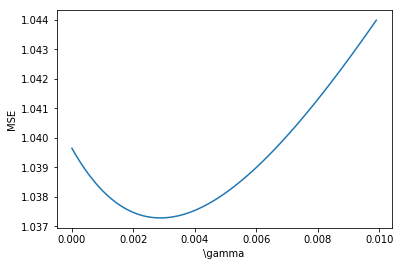

In [25]:
#Ridge regression
MSErr=[]
alpha=np.arange(0,0.01,0.0001)
for i in alpha:
    rr = linear_model.Ridge(alpha=i,fit_intercept=False)
    rr.fit(X_tr,y_tr)
    y_pred = rr.predict(X_te)
    MSErr.append(metrics.mean_squared_error(y_te,y_pred))
    
#plot
plt.plot(alpha,MSErr)
#plt.ylim(0,50)
plt.xlabel('\gamma')
plt.ylabel('MSE')
MSErr[0]# This is exactly same as OLS loss

In [26]:
print('tuned gamma = ',alpha[np.argmin(MSErr)])

tuned gamma =  0.0029000000000000002


In [62]:
#residuals
y_tr = y_tr - np.mean(y_tr)

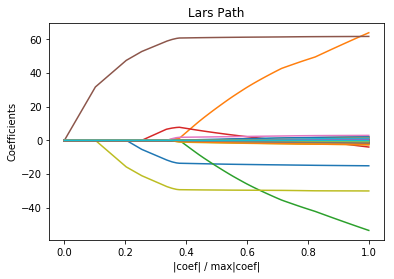

In [27]:
#Fitting the lasso path
# Run lars with lasso mod, find active set
lambdas,active,coefs = linear_model.lars_path(X_tr,y_tr,method="lasso")
plot_lars(coefs,lines=False)



(0.9, 1.2)

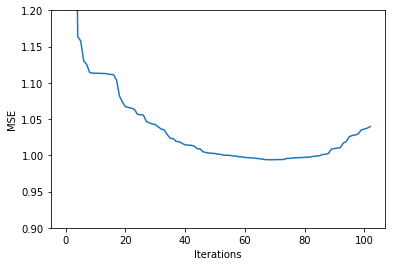

In [42]:
#compute test error
y_pred = X_te@coefs
MSElas = np.mean((y_te.reshape((len(y_te),1))@np.ones((1,coefs.shape[1])) - y_pred)**2,axis=0)


plt.plot(np.arange(0,coefs.shape[1]),MSElas)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.ylim(0.9,1.2)


In [29]:
print('lowest test error model = Error :',np.min(MSE),' at iter: ',np.argmin(MSE), 'with ',np.sum(coefs[:,np.argmin(MSE)]!=0), ' parameters')


lowest test error model = Error : 0.9938410330702546  at iter:  69 with  69  parameters


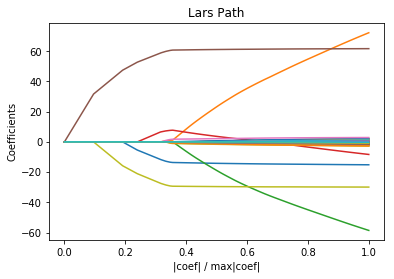

In [31]:
#Lars path
#Fitting the lars path
# Run lars with lars mod, find active set
lambdas2,active2,coefs2 = linear_model.lars_path(X_tr,y_tr,method="lars")
plot_lars(coefs2,lines=False)

The key difference between Lars and Lasso:
In Lars, the parameters never leave and in each iteration the subset size grows, but in Lasso, parameters can leave the active set if that's a linear combination of other parameters.

In [41]:
#check the difference of the active sets of lars and lasso
for iteration in range(1,coefs2.shape[1]):
    activeSetLas = set(np.nonzero(coefs[:,iteration])[0])
    activeSetLar = set(np.nonzero(coefs2[:,iteration])[0])
    difference = activeSetLar.symmetric_difference(activeSetLas)
    if(len(difference)!=0):
        print(iteration,' : ',difference)
 #at each iteration these are the difference of the active sets

70  :  {3}
71  :  {3}
72  :  {3}
73  :  {3}
74  :  {3}
75  :  {3, 23, 34}
76  :  {3}
77  :  {3, 16, 58}
78  :  {3, 16, 40}
79  :  {3, 40, 99}
80  :  {3, 40, 99}
81  :  {3}
82  :  {3, 30, 93}
83  :  {3, 87, 93}
84  :  {3, 87, 93}
85  :  {3, 21, 45, 87, 93}
86  :  {3, 45, 79, 87, 93}
87  :  {3, 45, 59, 79, 87}
88  :  {45, 59, 87}
89  :  {45, 59, 87}
90  :  {45}
91  :  {33}
92  :  {32}
93  :  {43}
94  :  {25, 43, 82}
95  :  {25, 61, 82}
96  :  {25, 37, 61}
97  :  {37, 55, 61}
98  :  {37, 55, 61}
99  :  {37, 55, 61}
100  :  {37}
101  :  {37}


[ 0  1  2  3  5  8 27 38 50 52 53 68 69 76 77 78 80 91 96 97]


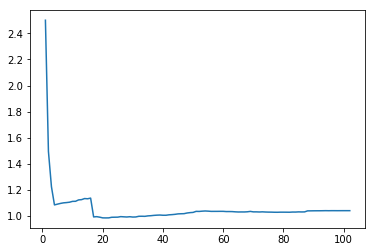

In [57]:
#5. fitting restricted LOS for each active set of the lasso path
MSE=[]
for iteration in range(1,coefs.shape[1]):
    activeSet = np.nonzero(coefs[:,iteration])[0]
    #print(iteration, activeSet)
    X_tr_res = X_tr[:,activeSet]
    X_te_res = X_te[:,activeSet]
    
    #train
    lr = linear_model.LinearRegression(fit_intercept=False)
    lr.fit(X_tr_res,y_tr)

    #predict
    MSE.append(metrics.mean_squared_error(y_te,lr.predict(X_te_res)))
    if (iteration==20):
        print(activeSet)
plt.plot(np.arange(1,coefs.shape[1]),MSE)    

    

In [34]:
print('lowest test error model = Error :',np.min(MSE),' at iter: ',np.argmin(MSE), 'with ',np.sum(coefs[:,np.argmin(MSE)]!=0), ' parameters')

lowest test error model = Error : 0.9840561908608665  at iter:  20 with  20  parameters


Text(0, 0.5, 'MSELas - MSE')

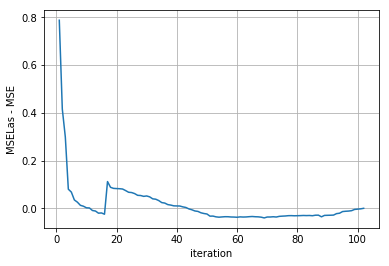

In [47]:
#Compare the test errors
plt.plot(np.arange(1,coefs.shape[1]),MSElas[1:] - MSE)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('MSELas - MSE')

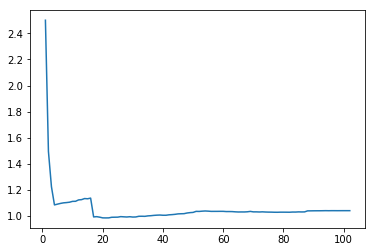

In [50]:
plt.plot(np.arange(1,coefs.shape[1]),MSE)   

A parsimonious model would be the model at 16th iteration with active set : [ 0  1  3  5  8 27 38 50 52 69 77 78 80 91 96 97]. HAs only 16 paramers and the error is in the 0.99 range. Not much difference with the smallest error model

The lowest error model with 20 paramerts with activeset: [ 0  1  2  3  5  8 27 38 50 52 53 68 69 76 77 78 80 91 96 97]
We can choose this we dont have a huge number of inferences after fitting the model that demands more computational power.
